In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pylab
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest

In [186]:
data_wti = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Oil Market\Datasets\wti-daily_csv.csv', parse_dates=['Date'])
data_rents = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Oil Market\Datasets\Oil rents by country.csv', header=[2])
wti_last_month = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Oil Market\Datasets\DCOILWTICO.csv', parse_dates=['DATE'])

In [188]:
rents_ecu = data_rents[(data_rents['Country Name'] == 'Ecuador')].T

In [189]:
rents_ecu

,66
Country Name,Ecuador
Country Code,ECU
Indicator Name,Oil rents (% of GDP)
Indicator Code,NY.GDP.PETR.RT.ZS
1960,NaN
...,...
2018,7.166329
2019,6.610501
2020,4.394566
2021,NaN


<AxesSubplot:>

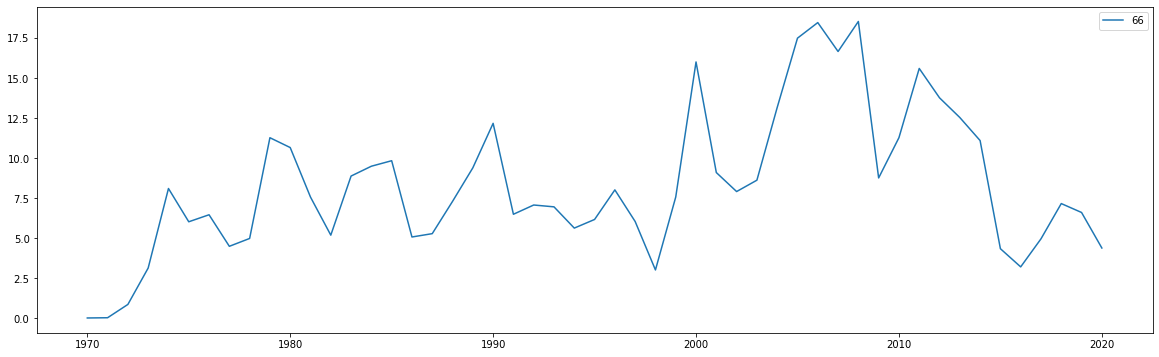

In [5]:
rents_ecu.iloc[14:-2].plot(figsize=(20,6))

In [6]:
data_wti.Date.describe()

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_16880\1887816428.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data_wti.Date.describe()


count                    9232
unique                   9232
top       1986-01-02 00:00:00
freq                        1
first     1986-01-02 00:00:00
last      2022-08-22 00:00:00
Name: Date, dtype: object

In [193]:
data_wti.set_index('Date', inplace=True)

In [194]:
data_wti.head(3)

,Price
Date,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53


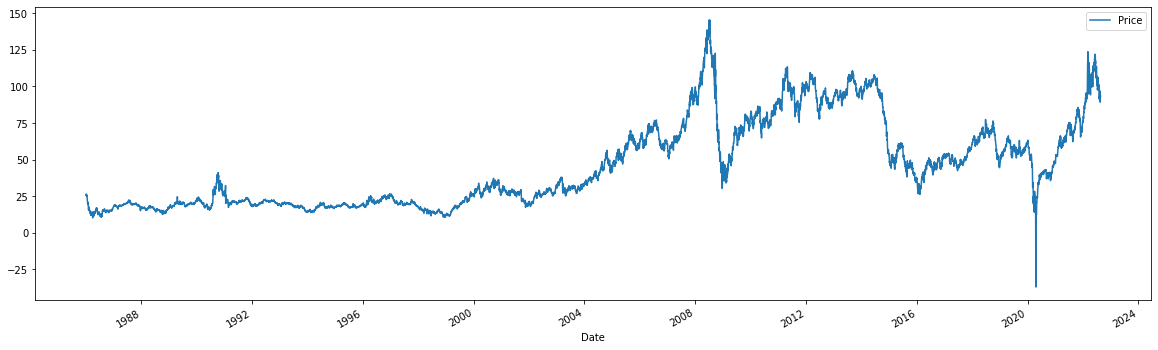

In [9]:
data_wti.plot(figsize=(20,6));

## Key Dates for Oil Industry

In [406]:
gulf_war = '1990-10-2'
attack_911 = '2001-9-11' 
fina_crisis = '2008-9-25'
peak_shale = '2014-6-20'
covid_19 = '2019-12-31'
war_rus_ukr = '2022-05-24'
train_date = '2022-08-22'

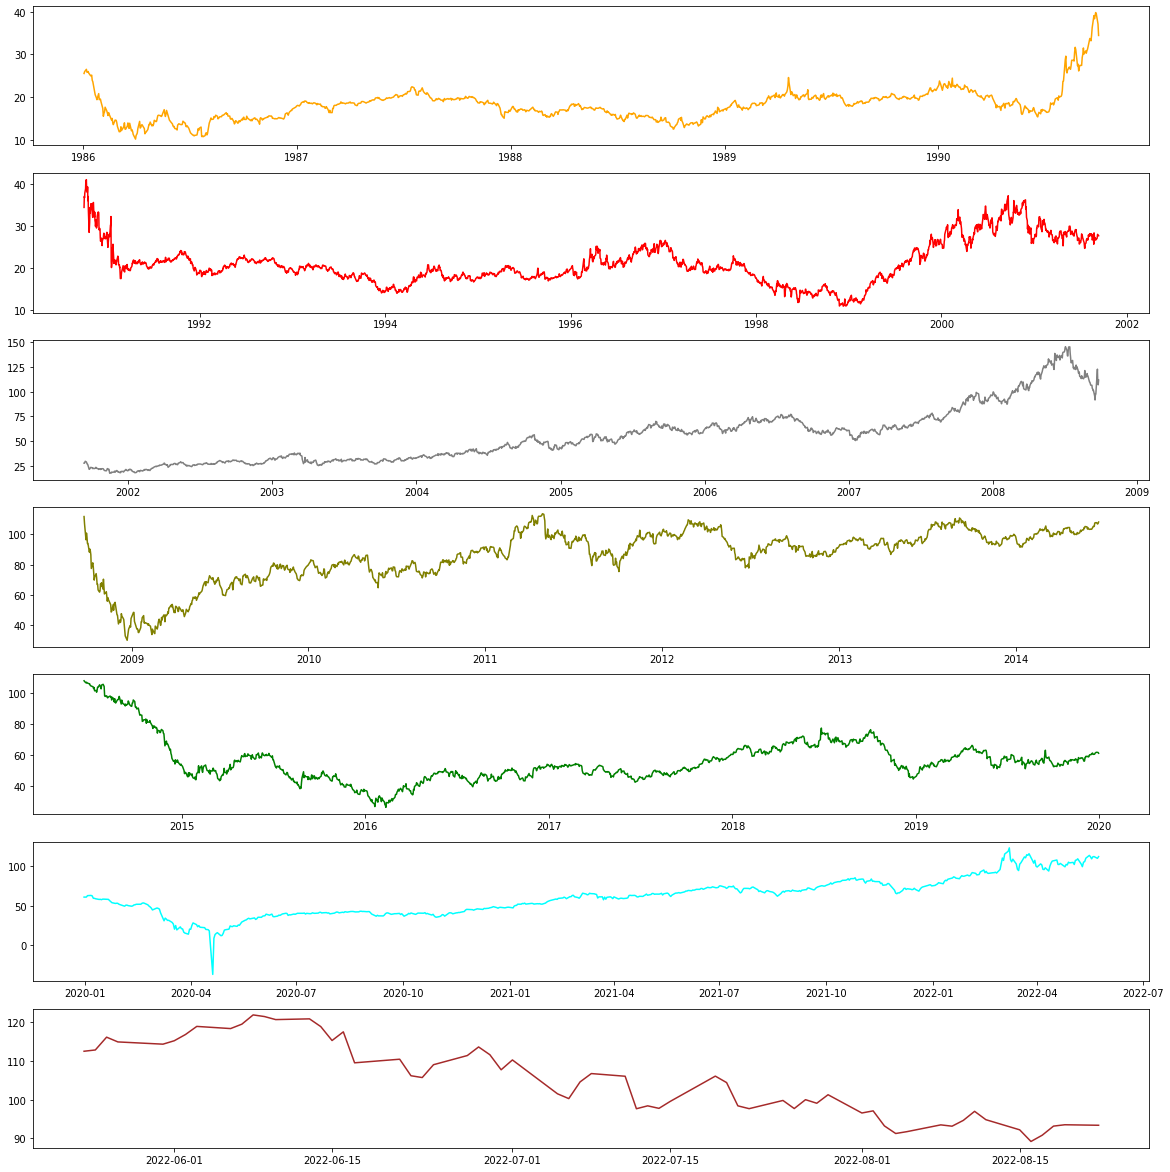

In [407]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, figsize=(20,21))
ax1.plot(data_wti[:gulf_war], color='orange')
ax2.plot(data_wti[gulf_war:attack_911], color='red')
ax3.plot(data_wti[attack_911:fina_crisis], color='gray')
ax4.plot(data_wti[fina_crisis:peak_shale], color='olive')
ax5.plot(data_wti[peak_shale:covid_19], color='green')
ax6.plot(data_wti[covid_19:war_rus_ukr], color='cyan')
ax7.plot(data_wti[war_rus_ukr:], color='brown')
plt.show()

In [408]:
data_wti.describe()

,Price
count,9232.000000
mean,45.661145
std,29.492842
min,-36.980000
25%,19.940000
50%,34.910000
75%,66.035000
max,145.310000


### Normal Distribution

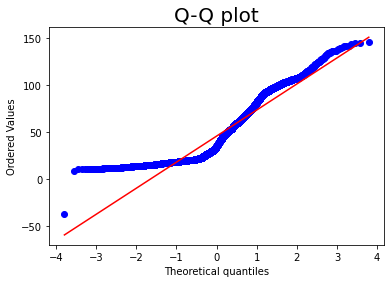

In [409]:
scipy.stats.probplot(data_wti.Price, plot=pylab)
plt.title('Q-Q plot', size=20)
pylab.show() 

In [410]:
data_wti.describe()

,Price
count,9232.000000
mean,45.661145
std,29.492842
min,-36.980000
25%,19.940000
50%,34.910000
75%,66.035000
max,145.310000


### Stationarity

In [411]:
# Determine p-value to determine if data is stationary
sts.adfuller(data_wti)

(-2.213377714641542,
 0.2014259950861617,
 38,
 9193,
 {'1%': -3.4310615334378807,
  '5%': -2.861854452413968,
  '10%': -2.5669373779569864},
 32747.08402618017)

### Seasonality

In [412]:
price_wti = data_wti.asfreq('B')
price_wti.isnull().sum()

Price    326
dtype: int64

In [413]:
price_wti = price_wti.fillna(value=price_wti.mean())
price_wti = price_wti[war_rus_ukr:]

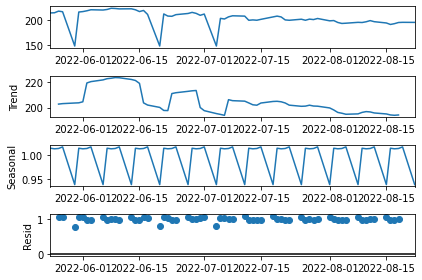

In [414]:
s_dec_multiplicative = seasonal_decompose((price_wti + price_wti.mean()), model = "multiplicative")
s_dec_multiplicative.plot()
plt.show()

## Prices

### ACF

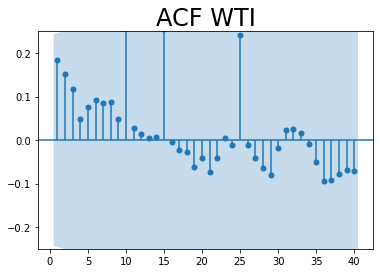

In [415]:
sgt.plot_acf(price_wti, lags=40, zero=False)
plt.title("ACF WTI", size = 24)
plt.ylim(-0.25, 0.25)
plt.show()

### PACF

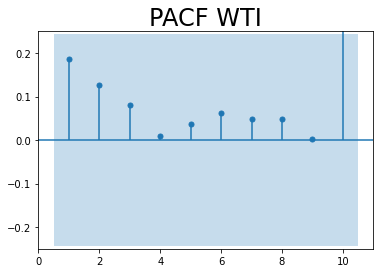

In [416]:
sgt.plot_pacf(price_wti.Price, lags = 10, zero = False, method = ('ols'))
plt.title("PACF WTI", size = 24)
plt.ylim(-0.25,0.25)
plt.show()

### Auto Regresive Modeling

In [417]:
model_ar_15 = ARIMA(price_wti.Price, order=(15,0,0))
results_ar_15 = model_ar_15.fit()
results_ar_15.summary()

c:\Users\USUARIO\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                   65
Model:                ARIMA(15, 0, 0)   Log Likelihood                -260.016
Date:                Fri, 23 Sep 2022   AIC                            554.033
Time:                        22:46:14   BIC                            590.997
Sample:                    05-24-2022   HQIC                           568.618
                         - 08-22-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        102.6841     10.093     10.173      0.000      82.901     122.467
ar.L1          0.1439      0.174      0.825      0.409      -0.198       0.486
ar.L2          0.1221      0.200      0.611      0.541      -0.269       0.513
ar.L3          0.1048      0.191      0.548      0.584      -0.270       0.479
ar.L4          0.0184      0.219      0.084      0.933      -0.411       0.448
ar.L5         -0.2030      0.119     -1.700      0.089      -0.437       0.031
ar.L6          0.0864      0.176      0.491      0.624      -0.259       0.431
ar.L7          0.0144      0.187      0.077      0.939      -0.352       0.380
ar.L8          0.0109      0.199      0.055      0.956      -0.379       0.400
ar.L9         -0.0575      0.211     -0.273      0.785      -0.471       0.356
ar.L10         0.3749      0.080      4.665      0.000       0.217       0.532
ar.L11        -0.0470      0.357     -0.132      0.895      -0.747       0.653
ar.L12        -0.0720      0.304     -0.237      0.813      -0.667       0.523
ar.L13        -0.0665      0.205     -0.325      0.745      -0.468       0.335
ar.L14        -0.0152      0.192     -0.079      0.937      -0.392       0.361
ar.L15         0.4481      0.081      5.506      0.000       0.289       0.608
sigma2       161.5465     25.376      6.366      0.000     111.810     211.283
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                75.16
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                            -1.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Analysing the Residuals

In [418]:
price_wti['p_resid_ar_15'] = results_ar_15.resid

In [419]:
price_wti.p_resid_ar_15.mean(), price_wti.p_resid_ar_15.var()

(-1.5359187975720072, 191.83653671149366)

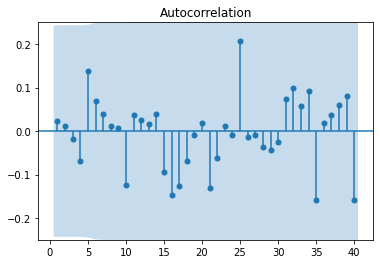

In [420]:
sgt.plot_acf(price_wti.p_resid_ar_15, zero=False, lags=40)
plt.ylim(-0.25,0.25)
plt.show()

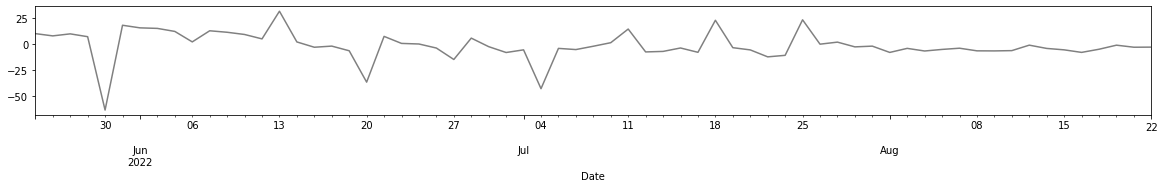

In [421]:
price_wti.p_resid_ar_15.plot(figsize=(20,2), color='grey');

### Auto Regresive Moving Average Modeling

In [422]:
model_ar_15_ma_3 = ARIMA(price_wti.Price, order=(15,0,3))
results_ar_15_ma_3 = model_ar_15_ma_3.fit()
results_ar_15_ma_3.summary()

c:\Users\USUARIO\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                   65
Model:                ARIMA(15, 0, 3)   Log Likelihood                -258.418
Date:                Fri, 23 Sep 2022   AIC                            556.835
Time:                        22:46:16   BIC                            600.323
Sample:                    05-24-2022   HQIC                           573.994
                         - 08-22-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        102.2666      7.768     13.165      0.000      87.041     117.492
ar.L1         -0.6049      0.295     -2.049      0.041      -1.184      -0.026
ar.L2         -0.4222      0.263     -1.602      0.109      -0.939       0.094
ar.L3         -0.1945      0.284     -0.685      0.493      -0.751       0.362
ar.L4          0.2433      0.296      0.823      0.411      -0.336       0.823
ar.L5         -0.0858      0.237     -0.361      0.718      -0.551       0.380
ar.L6          0.1059      0.191      0.555      0.579      -0.268       0.480
ar.L7          0.0803      0.214      0.376      0.707      -0.339       0.499
ar.L8          0.0892      0.261      0.342      0.733      -0.423       0.601
ar.L9          0.0090      0.303      0.030      0.976      -0.585       0.603
ar.L10         0.3657      0.258      1.416      0.157      -0.140       0.872
ar.L11         0.2053      0.309      0.665      0.506      -0.399       0.810
ar.L12         0.1122      0.451      0.248      0.804      -0.773       0.997
ar.L13         0.0058      0.420      0.014      0.989      -0.818       0.829
ar.L14        -0.1799      0.368     -0.489      0.625      -0.901       0.541
ar.L15         0.2808      0.294      0.956      0.339      -0.295       0.856
ma.L1          0.8806      0.296      2.976      0.003       0.301       1.461
ma.L2          0.8501      0.223      3.817      0.000       0.414       1.287
ma.L3          0.6679      0.284      2.352      0.019       0.111       1.225
sigma2       151.7540     36.862      4.117      0.000      79.506     224.002
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                39.61
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -1.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Analysing the Residuals

In [423]:
price_wti['p_resid_ar15_ma3'] = results_ar_15_ma_3.resid

In [424]:
price_wti.p_resid_ar15_ma3.mean(), price_wti.p_resid_ar15_ma3.var(),

(-0.2866389660122019, 189.92783315094684)

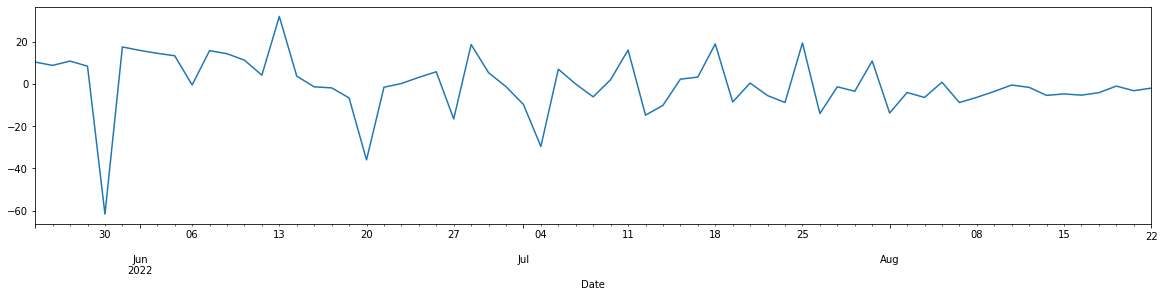

In [425]:
price_wti.p_resid_ar15_ma3.plot(figsize=(20,4));

## Returns

In [426]:
price_wti['p_returns'] = price_wti.Price.pct_change(1).mul(100)
price_wti = price_wti[1:]

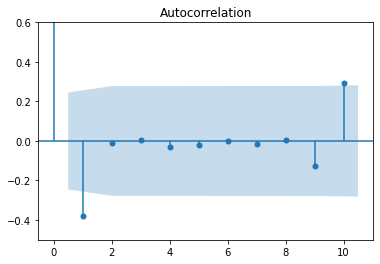

In [427]:
sgt.plot_acf(price_wti.p_returns, lags=10)
plt.ylim(-0.5,0.6)
plt.show()

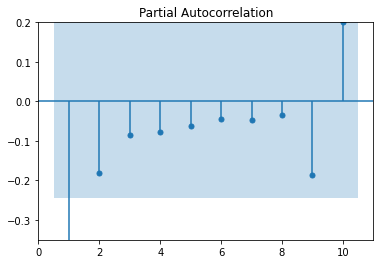

In [428]:
sgt.plot_pacf(price_wti.p_returns, lags = 10, zero = False, method = ('ols'))
plt.ylim(-0.35,0.2)
plt.show()

### Auto Regresive Modeling

In [429]:
model_ret_ar_5 = ARIMA(price_wti.p_returns, order=(5, 0, 0))
results_ret_ar_5 = model_ret_ar_5.fit()
results_ret_ar_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              p_returns   No. Observations:                   64
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -307.255
Date:                Fri, 23 Sep 2022   AIC                            628.509
Time:                        22:46:18   BIC                            643.622
Sample:                    05-25-2022   HQIC                           634.463
                         - 08-22-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6740      3.477      1.057      0.291      -3.140      10.488
ar.L1         -0.4670      0.115     -4.044      0.000      -0.693      -0.241
ar.L2         -0.2386      0.263     -0.908      0.364      -0.754       0.276
ar.L3         -0.1333      0.486     -0.274      0.784      -1.085       0.819
ar.L4         -0.1087      0.563     -0.193      0.847      -1.212       0.995
ar.L5         -0.0848      0.515     -0.165      0.869      -1.094       0.924
sigma2       862.0248    131.559      6.552      0.000     604.173    1119.877
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               128.87
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                             1.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Analyzing Residuals of Returns

In [430]:
price_wti['p_ret_resid_ar_5'] = results_ret_ar_5.resid

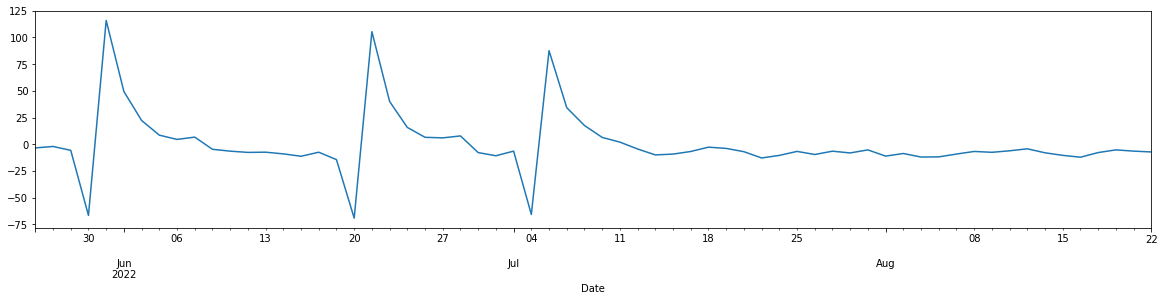

In [431]:
price_wti.p_ret_resid_ar_5.plot(figsize=(20,4));

In [432]:
price_wti.p_ret_resid_ar_5.mean(), price_wti.p_ret_resid_ar_5.var()

(-0.06253110987671873, 878.1257040995923)

### Auto Regresive Moving Average Modeling

In [433]:
model_ret_ar5_ma5 = ARIMA(price_wti.p_returns, order=(5,0,5))
results_ret_ar5_ma5 = model_ret_ar5_ma5.fit()
results_ret_ar5_ma5.summary()

c:\Users\USUARIO\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\USUARIO\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\USUARIO\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              p_returns   No. Observations:                   64
Model:                 ARIMA(5, 0, 5)   Log Likelihood                -306.620
Date:                Fri, 23 Sep 2022   AIC                            637.241
Time:                        22:46:19   BIC                            663.147
Sample:                    05-25-2022   HQIC                           647.447
                         - 08-22-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6269      3.614      1.004      0.316      -3.456      10.710
ar.L1         -0.5996      1.315     -0.456      0.648      -3.177       1.978
ar.L2          0.1414      1.380      0.103      0.918      -2.563       2.846
ar.L3          0.7679      1.245      0.617      0.537      -1.672       3.208
ar.L4          0.8006      0.885      0.905      0.365      -0.933       2.535
ar.L5         -0.1964      0.757     -0.259      0.795      -1.680       1.288
ma.L1          0.1429      7.343      0.019      0.984     -14.249      14.535
ma.L2         -0.5028      7.695     -0.065      0.948     -15.584      14.578
ma.L3         -0.7559      5.002     -0.151      0.880     -10.560       9.048
ma.L4         -0.4911      2.034     -0.241      0.809      -4.478       3.496
ma.L5          0.6085      4.476      0.136      0.892      -8.165       9.382
sigma2       822.1178   5172.633      0.159      0.874   -9316.057     1.1e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               121.63
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                             1.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Returns vs. Predictions

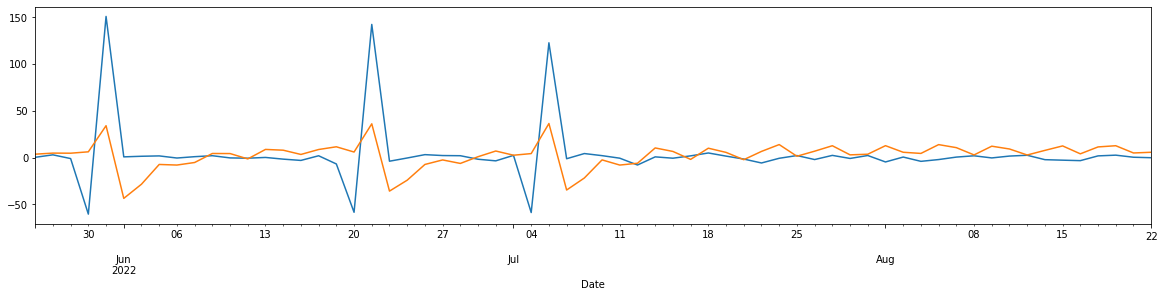

In [434]:
price_wti.p_returns.plot(figsize=(20,4))
results_ret_ar5_ma5.predict().plot(figsize=(20,4))
plt.show()

#### Analyzing ARMA Residuals

In [435]:
price_wti['p_ret_resid_ar5_ma5'] = results_ret_ar5_ma5.resid

In [436]:
price_wti.p_ret_resid_ar5_ma5.mean(), price_wti.p_ret_resid_ar5_ma5.var()

(1.059343295080871, 864.2018060466914)

## Auto-ARIMA Modeling

In [437]:
mod_auar_li = auto_arima(price_wti.Price, m=10, max_p=10, max_q=10, max_P=10, max_Q=10, trend='ct')

In [438]:
results_auar_li = mod_auar_li.fit(price_wti.Price)
results_auar_li.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   64
Model:             SARIMAX(3, 1, 1)x(0, 0, 1, 10)   Log Likelihood                -256.545
Date:                            Fri, 23 Sep 2022   AIC                            529.091
Time:                                    22:46:43   BIC                            546.236
Sample:                                         0   HQIC                           535.834
                                             - 64                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0023      0.864      0.003      0.998      -1.690       1.695
drift         -0.0070      0.036     -0.197      0.844      -0.077       0.063
ar.L1          0.1247      0.208      0.600      0.548      -0.282       0.532
ar.L2          0.0980      0.250      0.392      0.695      -0.392       0.588
ar.L3          0.0345      0.247      0.140      0.889      -0.449       0.518
ma.L1         -0.9788      0.326     -3.006      0.003      -1.617      -0.341
ma.S.L10       0.6091      0.182      3.348      0.001       0.253       0.966
sigma2       197.6189     60.580      3.262      0.001      78.884     316.354
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               364.39
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                            -2.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [439]:
wti_pred = mod_auar_li.predict(n_periods=20)

In [479]:
wti_test = wti_last_month.rename(columns={'DATE':'Date', 'DCOILWTICO':'Price'})
wti_test = wti_test.set_index('Date')
wti_test = wti_test[train_date:]

In [480]:
wti_test.replace('.',np.nan, inplace=True)

In [481]:
wti_test.fillna(method='ffill', inplace=True)

In [482]:
wti_test = wti_test[1:]

In [483]:
wti_test = wti_test.Price.astype('float32')

In [491]:
wti_test = pd.DataFrame(wti_test)
wti_test.Price.to_list()

[96.45999908447266,
 95.5199966430664,
 93.33000183105469,
 93.62999725341797,
 97.4000015258789,
 92.08000183105469,
 90.08999633789062,
 87.08999633789062,
 87.29000091552734,
 87.29000091552734,
 87.3499984741211,
 82.5,
 84.04000091552734,
 87.2699966430664,
 88.18000030517578,
 87.83999633789062,
 88.87999725341797,
 85.72000122070312,
 85.56999969482422,
 86.1500015258789]

In [444]:
wti_test['P_pred'] = wti_pred

In [464]:
pd.DataFrame(wti_test.Price).values

array([['96.46'],
       ['95.52'],
       ['93.33'],
       ['93.63'],
       ['97.4'],
       ['92.08'],
       ['90.09'],
       ['87.09'],
       ['87.29'],
       ['87.29'],
       ['87.35'],
       ['82.5'],
       ['84.04'],
       ['87.27'],
       ['88.18'],
       ['87.84'],
       ['88.88'],
       ['85.72'],
       ['85.57'],
       ['86.15']], dtype=object)